In [17]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from itertools import product

# Load Images

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [15]:
numbers = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
indices = {num: np.where(y_train == num)[0][0] for num in numbers}
images = {num: x_train[idx] for num, idx in indices.items()}

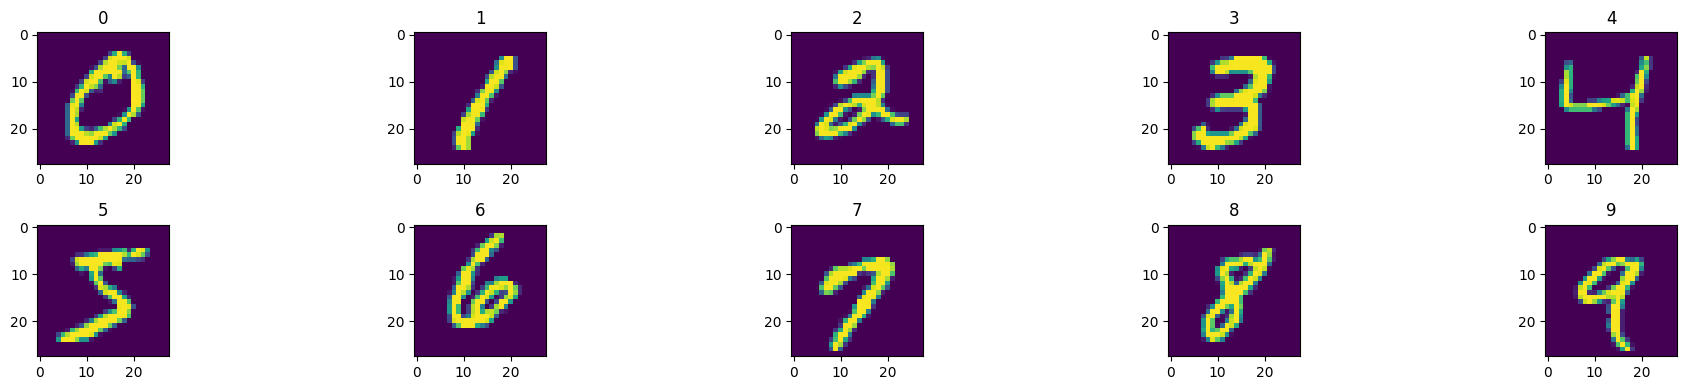

In [39]:
fig, ax = plt.subplots(2, 5, figsize=(20, 4))

ctr = 0
for row, column in product(range(2), range(5)):
    ax[row, column].imshow(images[ctr])
    ax[row, column].set_title(ctr)
    ctr += 1
    
fig.tight_layout()
plt.show()

# Apply FFT to Images

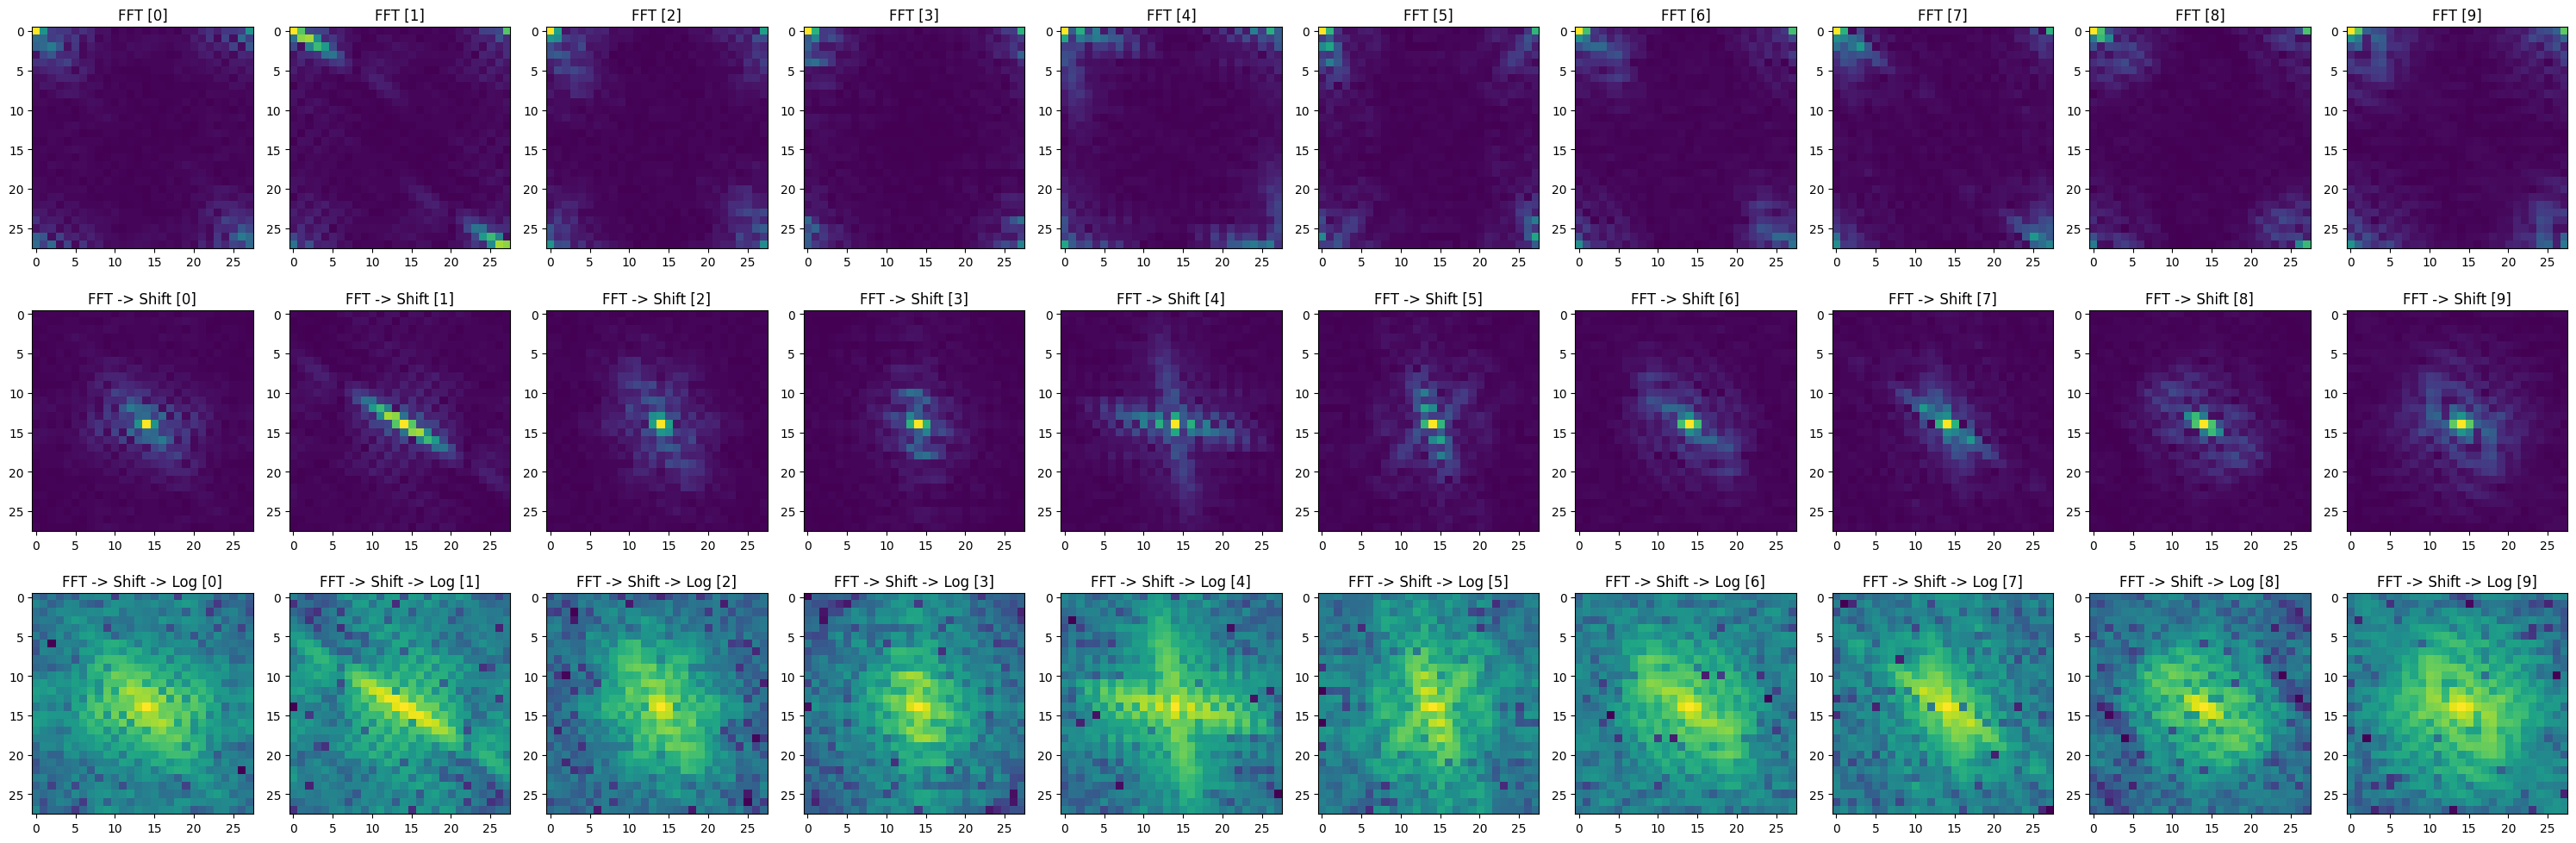

In [73]:
fig, ax = plt.subplots(3, 10, figsize=(30, 10))

for row, col in product(range(3), range(10)):
    img = images[col]
    f_transform = np.fft.fft2(img)
    f_shift = np.fft.fftshift(f_transform)
    f_magnitude_spectrum = np.log1p(np.abs(f_shift))
    
    if row == 0:
        lbl = 'FFT'
        ax[0, col].imshow(np.abs(f_transform))
    elif row == 1:
        lbl = 'FFT -> Shift'
        ax[1, col].imshow(np.abs(f_shift))
    else:
        lbl = 'FFT -> Shift -> Log'
        ax[2, col].imshow(f_magnitude_spectrum)
        
    ax[row, col].set_title(lbl + f' [{col}]')
        
fig.tight_layout()
plt.show()

# Crop FFT Spectrum

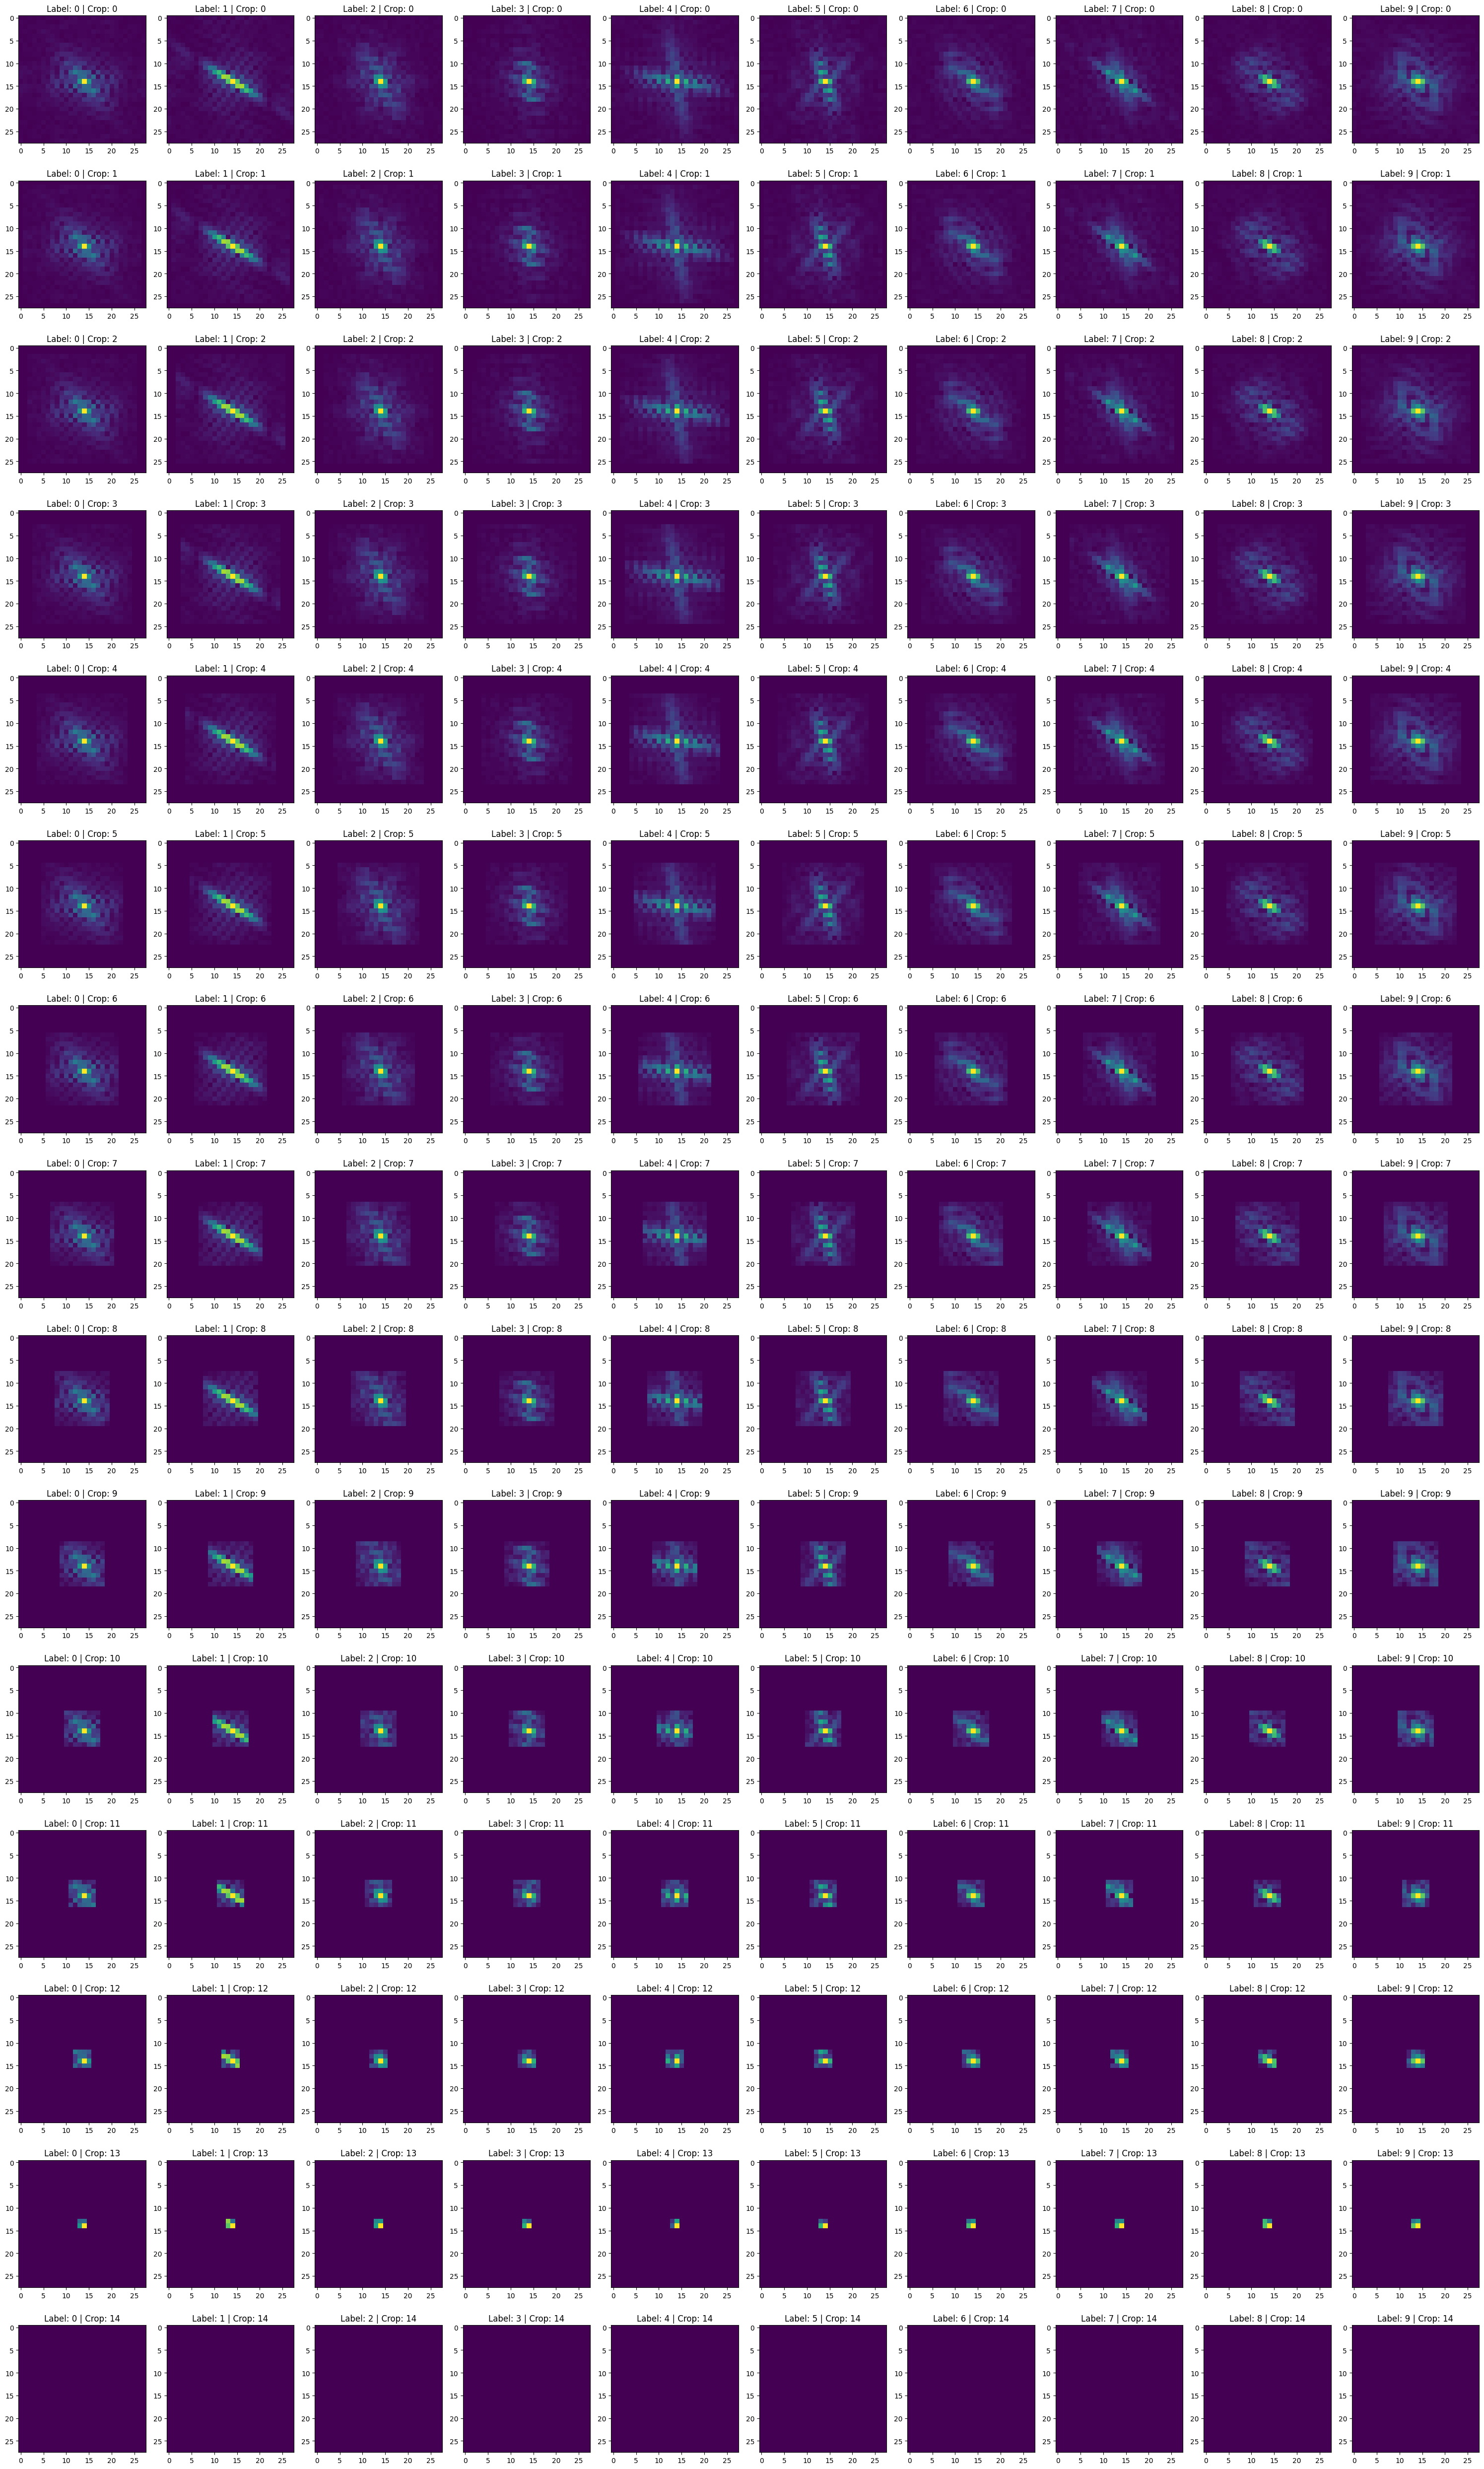

In [153]:
fig, ax = plt.subplots(15, 10, figsize=(30, 50))

for row, col in product(range(15), range(10)):
    img = images[col]
    
    f_transform = np.fft.fft2(img)
    f_shift = np.fft.fftshift(f_transform)
    
    border_size = row
    f_shift_cropped = np.copy(f_shift)
    f_shift_cropped[:border_size,:] = 0 
    f_shift_cropped[img.shape[0] - border_size:,:] = 0
    f_shift_cropped[:,:border_size] = 0 
    f_shift_cropped[:, img.shape[1] - border_size:] = 0
    
    ax[row, col].imshow(np.abs(f_shift_cropped))
    ax[row, col].set_title(f'Label: {col} | Crop: {row}')
    
fig.tight_layout()
plt.show()

# Reconstruct Cropped FFT Spectrum

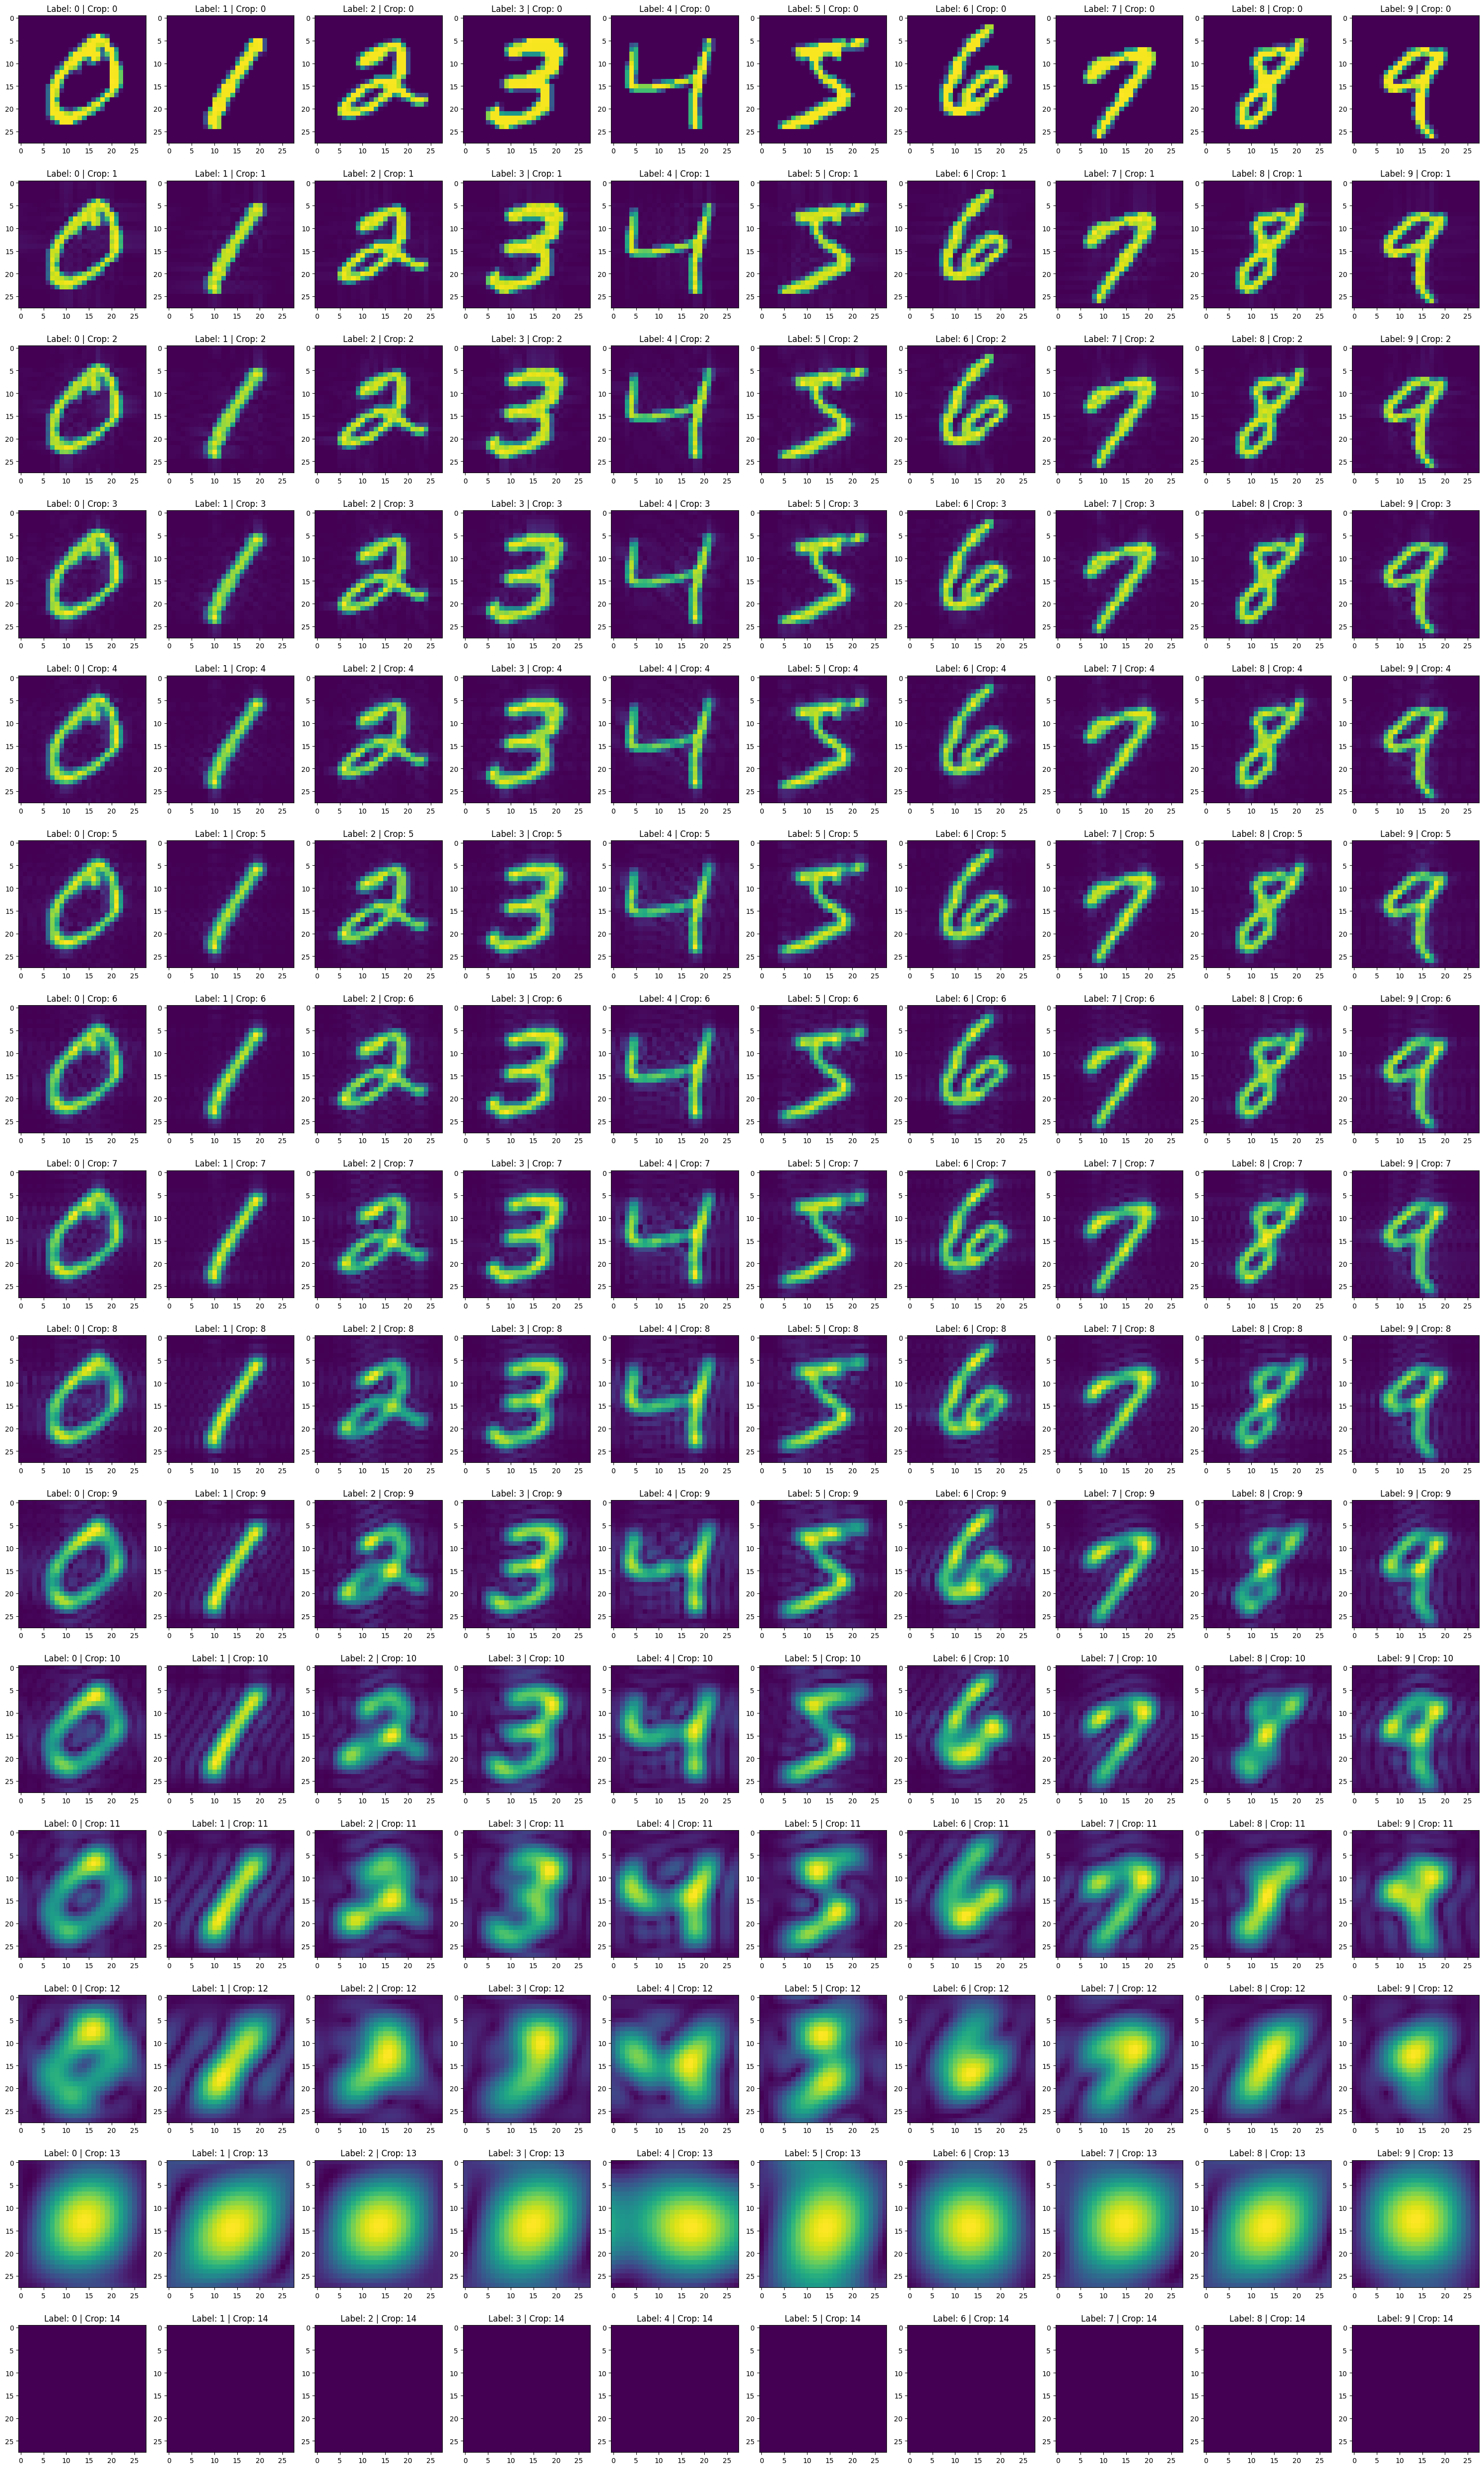

In [154]:
fig, ax = plt.subplots(15, 10, figsize=(30, 50))

for row, col in product(range(15), range(10)):
    img = images[col]
    
    f_transform = np.fft.fft2(img)
    f_shift = np.fft.fftshift(f_transform)
    
    border_size = row
    f_shift_cropped = np.copy(f_shift)
    f_shift_cropped[:border_size,:] = 0 
    f_shift_cropped[img.shape[0] - border_size:,:] = 0
    f_shift_cropped[:,:border_size] = 0 
    f_shift_cropped[:, img.shape[1] - border_size:] = 0
    
    f_ishift = np.fft.ifftshift(f_shift_cropped)
    f_itransform = np.fft.ifft2(f_ishift)
    
    ax[row, col].imshow(np.abs(f_itransform))
    ax[row, col].set_title(f'Label: {col} | Crop: {row}')
    
fig.tight_layout()
plt.show()

# Combine Functionality into a Class

In [155]:
from typing import Tuple

In [178]:
class SpectralConverter:
    def __init__(self, img_shape: Tuple[int, int]):
        self.img_shape_x = img_shape[0]
        self.img_shape_y = img_shape[1]
        
    def img_to_freq(self, img: np.ndarray, border_shape: Tuple[int, int] = (0, 0)):
        border_x = border_shape[0]
        border_y = border_shape[1]
        
        # Fourier Transform
        f_transform = np.fft.fft2(img)
        f_shift = np.fft.fftshift(f_transform)
        
        # Crop Image
        f_shift_cropped = f_shift[border_y:img.shape[0] - border_y, border_x:img.shape[1] - border_x]
        
        return f_shift_cropped
    
    def freq_to_img(self, freq: np.ndarray):
        img_center_x = self.img_shape_x // 2
        img_center_y = self.img_shape_y // 2
        
        freq_center_x = freq.shape[1] // 2
        freq_center_y = freq.shape[0] // 2
        
        f_shift_cropped = np.zeros((self.img_shape_y, self.img_shape_x), dtype=complex)
        
        f_shift_cropped[img_center_y - freq_center_y:img_center_y + freq_center_y,img_center_x - freq_center_x:img_center_x + freq_center_x] = freq
        
        f_ishift = np.fft.ifftshift(f_shift_cropped)
        f_itransform = np.fft.ifft2(f_ishift)
        
        return np.abs(f_itransform)

# Test Class

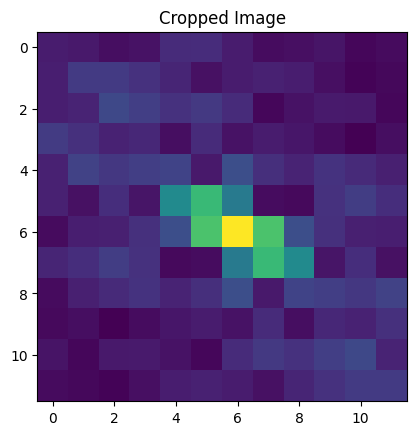

In [197]:
img = images[8]
converter = SpectralConverter(img_shape=img.shape)
freq = converter.img_to_freq(img, (8, 8))

plt.imshow(np.abs(freq))
plt.title('Cropped Image')
plt.show()

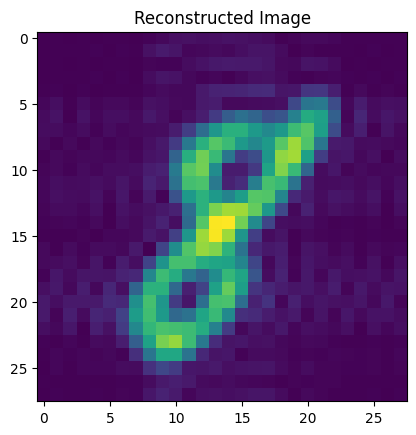

In [198]:
img = converter.freq_to_img(freq)

plt.imshow(img)
plt.title('Reconstructed Image')
plt.show()